# Exploratory data analysis

Notebook to look for features to predict home prices.

In [1]:
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from math import ceil

/var/folders/sy/trsj1fws3q56ylqm17n583900000gn/T/ipykernel_14616/3195470711.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Function to remove the seasonality (numpy array).

In [2]:
def remove_seasonality(data):
    """
    Function to remove the seasonality from a 1D numpy array
    """
    data_extend = np.concatenate([np.array([data[0]] * 6), data, np.array([data[-1]] * 6)])
    weights = np.array([0.5] + [1] * 11 + [0.5]) / 12
    m = np.convolve(data_extend, weights, 'valid')
    data_demean = data - m
    N = int(ceil(len(data_demean) / 12)) * 12 - len(data_demean)
    data_demean = np.concatenate([data_demean, np.repeat(np.nan, N)])
    deviations = np.reshape(data_demean, (-1, 12)).transpose()
    deviations = np.nanmean(deviations, axis=1)
    deviations = deviations - np.mean(deviations)
    N = int(ceil(len(data_demean) / 12))
    s = np.tile(deviations, N)[0:len(data)]
    data_sa = data - s
    return data_sa

Function to compute the correlation.

In [3]:
def rolling_corr(target, feature, N):
    df = pd.merge(target, feature, on=['date'], how='inner')
    target = df['United States_x'].to_numpy()
    feature = df['United States_y'].to_numpy()
    corr = np.zeros(N + 1)
    for i in range(0, N + 1):
        if i == 0:
            corr[i] = np.corrcoef(target, feature)[0, 1]
        else:
            corr[i] = np.corrcoef(target[i:], feature[0:-i])[0, 1]
    return corr

In [4]:
def rolling_corr_mortgage_rates(target, feature, N):
    df = pd.merge(target, feature, on=['date'], how='inner')
    target = df['United States'].to_numpy()
    feature = df['mortgage_rates'].to_numpy()
    corr = np.zeros(N + 1)
    for i in range(0, N + 1):
        if i == 0:
            corr[i] = np.corrcoef(target, feature)[0, 1]
        else:
            corr[i] = np.corrcoef(target[i:], feature[0:-i])[0, 1]
    return corr

## Target

In [5]:
target = pd.read_csv('data/2025_02/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_month.csv')
target = target.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])
target = target.rename(columns={'RegionName':'index'})
target = target.set_index('index')
target = target.stack().unstack(level=0)
target = target.reset_index()
target = target.rename(columns={'index': 'date'})
target['date'] = pd.to_datetime(target['date'])
target = target.sort_values(['date'])
date = target['date']
target_growth = target.drop(columns=['date']).pct_change()
target['date'] = date
target_growth['date'] = date
target_growth = target_growth.iloc[1:]
target_growth_sa = target_growth[['date', 'United States']]
target_growth_sa['United States'] = remove_seasonality(target_growth_sa['United States'].to_numpy())

/var/folders/sy/trsj1fws3q56ylqm17n583900000gn/T/ipykernel_14616/2542375837.py:11: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  target_growth = target.drop(columns=['date']).pct_change()
/var/folders/sy/trsj1fws3q56ylqm17n583900000gn/T/ipykernel_14616/2542375837.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_growth_sa['United States'] = remove_seasonality(target_growth_sa['United States'].to_numpy())


## Sales count

In [6]:
sales = pd.read_csv('data/2025_02/Metro_sales_count_now_uc_sfrcondo_month.csv')
sales = sales.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])
sales = sales.rename(columns={'RegionName':'index'})
sales = sales.set_index('index')
sales = sales.stack().unstack(level=0)
sales = sales.reset_index()
sales = sales.rename(columns={'index': 'date'})
sales['date'] = pd.to_datetime(sales['date'])
sales = sales.sort_values(['date'])
sales_sa = sales[['date', 'United States']]
sales_sa['United States'] = remove_seasonality(sales_sa['United States'].to_numpy())

/var/folders/sy/trsj1fws3q56ylqm17n583900000gn/T/ipykernel_14616/4022637740.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_sa['United States'] = remove_seasonality(sales_sa['United States'].to_numpy())


Non-seasonally adjusted data.

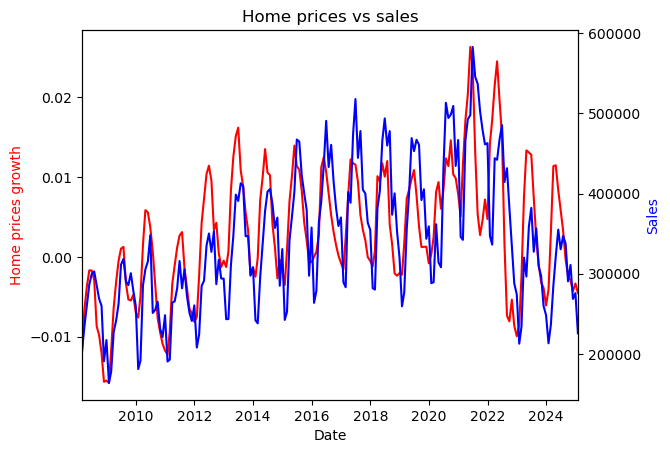

In [7]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth['date'], target_growth['United States'], 'r-') 
  
plt.title('Home prices vs sales')
ax1.set_xlim([max(target_growth['date'].min(), sales['date'].min()), \
          min(target_growth['date'].max(), sales['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Sales', color = 'blue') 
ax2.plot(sales['date'], sales['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and sales')

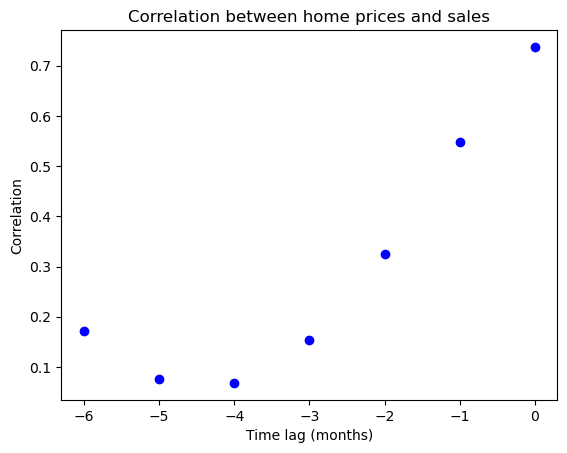

In [8]:
my_corr = rolling_corr(target_growth[['date', 'United States']],
                       sales[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and sales')

Seasonally adjusted data.

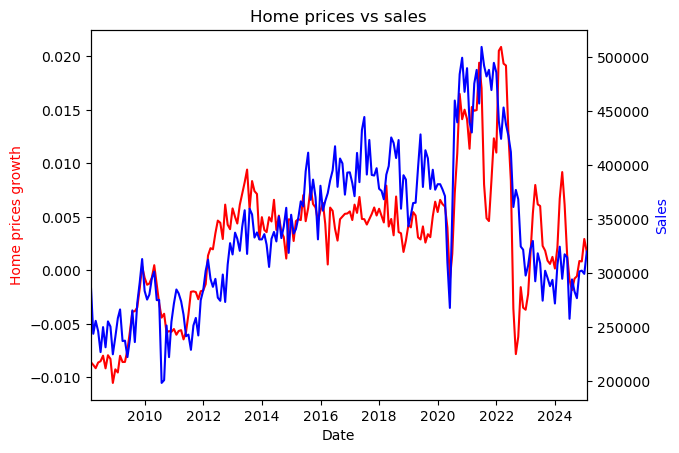

In [9]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth_sa['date'], target_growth_sa['United States'], 'r-') 
  
plt.title('Home prices vs sales')
ax1.set_xlim([max(target_growth_sa['date'].min(), sales_sa['date'].min()), \
          min(target_growth_sa['date'].max(), sales_sa['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Sales', color = 'blue') 
ax2.plot(sales_sa['date'], sales_sa['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and sales')

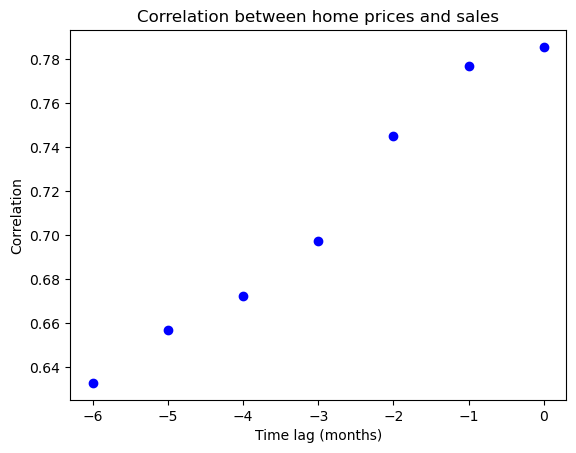

In [10]:
my_corr = rolling_corr(target_growth_sa[['date', 'United States']],
                       sales_sa[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and sales')

## Home inventory

In [11]:
inventory = pd.read_csv('data/2025_02/Metro_invt_fs_uc_sfrcondo_month.csv')
inventory = inventory.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])
inventory = inventory.rename(columns={'RegionName':'index'})
inventory = inventory.set_index('index')
inventory = inventory.stack().unstack(level=0)
inventory = inventory.reset_index()
inventory = inventory.rename(columns={'index': 'date'})
inventory['date'] = pd.to_datetime(inventory['date'])
inventory = inventory.sort_values(['date'])
inventory_sa = inventory[['date', 'United States']]
inventory_sa['United States'] = remove_seasonality(inventory_sa['United States'].to_numpy())

/var/folders/sy/trsj1fws3q56ylqm17n583900000gn/T/ipykernel_14616/1288314592.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inventory_sa['United States'] = remove_seasonality(inventory_sa['United States'].to_numpy())


Non-seasonally adjusted data.

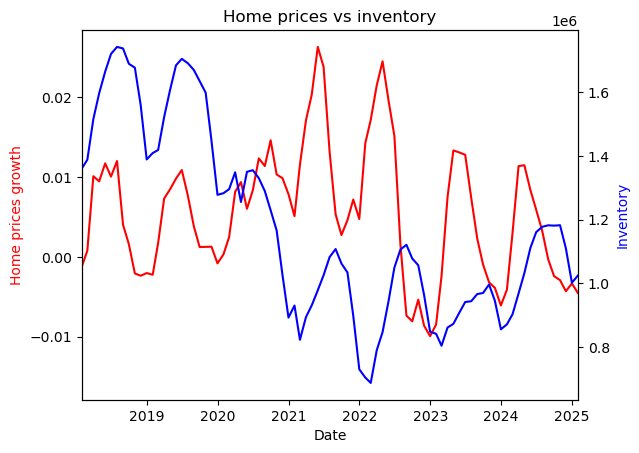

In [12]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth['date'], target_growth['United States'], 'r-') 
  
plt.title('Home prices vs inventory')
ax1.set_xlim([max(target_growth['date'].min(), inventory['date'].min()), \
          min(target_growth['date'].max(), inventory['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Inventory', color = 'blue') 
ax2.plot(inventory['date'], inventory['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and inventory')

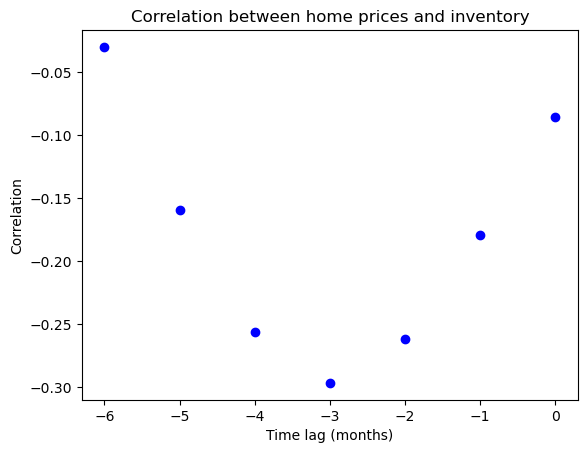

In [13]:
my_corr = rolling_corr(target_growth[['date', 'United States']],
                       inventory[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and inventory')

Seasonally adjusted data.

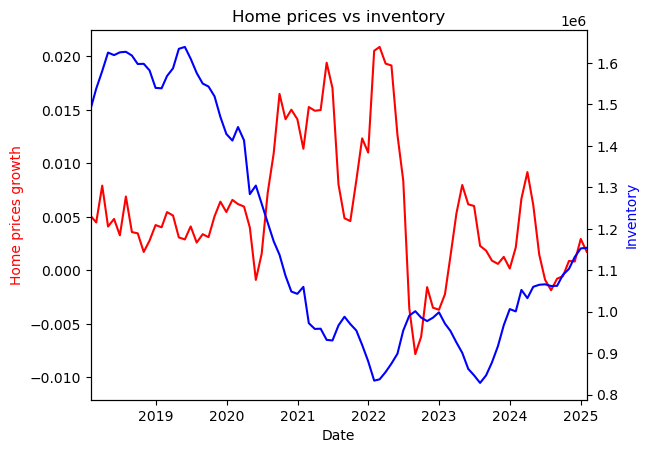

In [14]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth_sa['date'], target_growth_sa['United States'], 'r-') 
  
plt.title('Home prices vs inventory')
ax1.set_xlim([max(target_growth_sa['date'].min(), inventory_sa['date'].min()), \
          min(target_growth_sa['date'].max(), inventory_sa['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Inventory', color = 'blue') 
ax2.plot(inventory_sa['date'], inventory_sa['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and inventory')

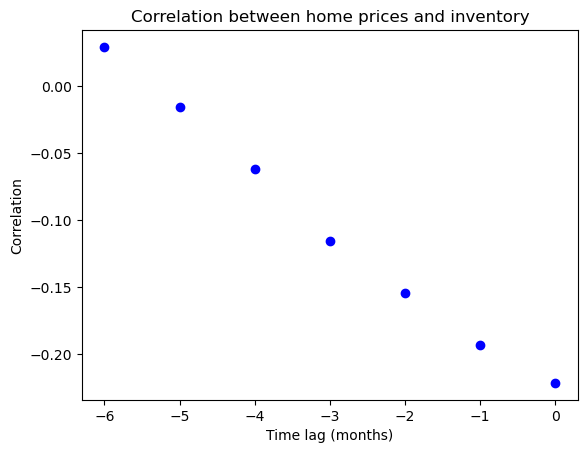

In [15]:
my_corr = rolling_corr(target_growth_sa[['date', 'United States']],
                       inventory_sa[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and inventory')

## New listings

In [16]:
new_listings = pd.read_csv('data/2025_02/Metro_new_listings_uc_sfrcondo_month.csv')
new_listings = new_listings.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])
new_listings = new_listings.rename(columns={'RegionName':'index'})
new_listings = new_listings.set_index('index')
new_listings = new_listings.stack().unstack(level=0)
new_listings = new_listings.reset_index()
new_listings = new_listings.rename(columns={'index': 'date'})
new_listings['date'] = pd.to_datetime(new_listings['date'])
new_listings = new_listings.sort_values(['date'])
new_listings_sa = new_listings[['date', 'United States']]
new_listings_sa['United States'] = remove_seasonality(new_listings_sa['United States'].to_numpy())

/var/folders/sy/trsj1fws3q56ylqm17n583900000gn/T/ipykernel_14616/2313853643.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_listings_sa['United States'] = remove_seasonality(new_listings_sa['United States'].to_numpy())


Non-seasonally adjusted data.

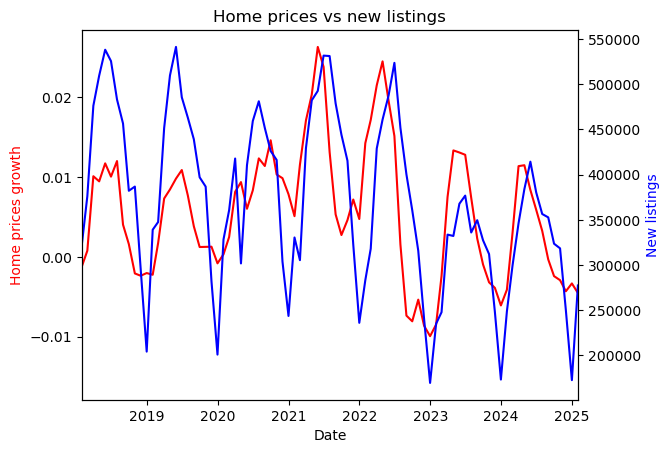

In [17]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth['date'], target_growth['United States'], 'r-') 
  
plt.title('Home prices vs new listings')
ax1.set_xlim([max(target_growth['date'].min(), new_listings['date'].min()), \
          min(target_growth['date'].max(), new_listings['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('New listings', color = 'blue') 
ax2.plot(new_listings['date'], new_listings['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and new listings')

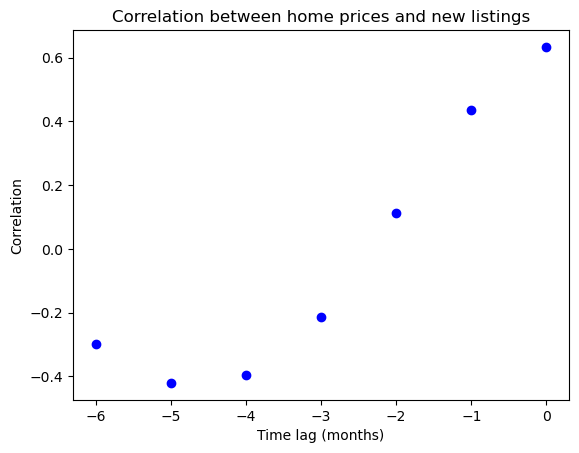

In [18]:
my_corr = rolling_corr(target_growth[['date', 'United States']],
                       new_listings[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and new listings')

Seasonally adjusted data.

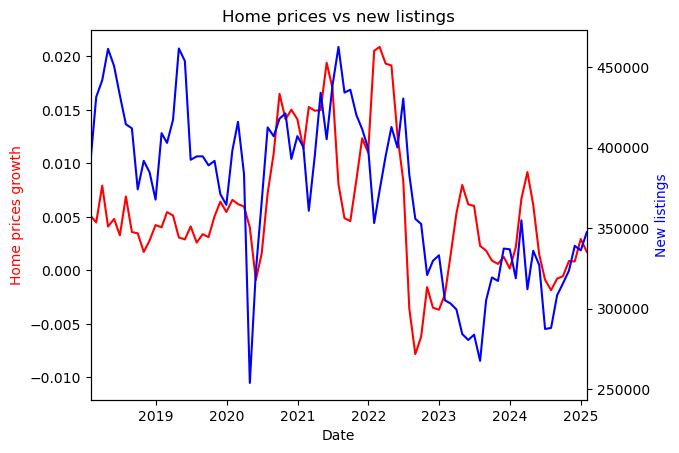

In [19]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth_sa['date'], target_growth_sa['United States'], 'r-') 
  
plt.title('Home prices vs new listings')
ax1.set_xlim([max(target_growth_sa['date'].min(), new_listings_sa['date'].min()), \
          min(target_growth_sa['date'].max(), new_listings_sa['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('New listings', color = 'blue') 
ax2.plot(new_listings_sa['date'], new_listings_sa['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and new listings')

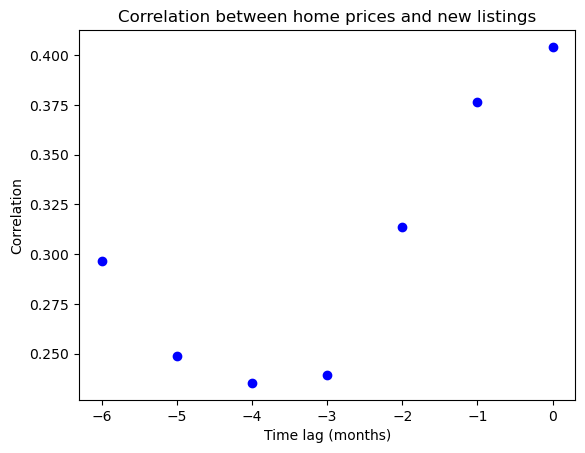

In [20]:
my_corr = rolling_corr(target_growth_sa[['date', 'United States']],
                       new_listings_sa[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and new listings')

## Mortgage rates

In [21]:
#mortgage_rates = pd.read_csv('mortgage_rates.csv')
#mortgage_rates = mortgage_rates.rename(columns={'DATE': 'date', 'MORTGAGE30US': 'mortgage_rates'})
#mortgage_rates['date'] = pd.to_datetime(mortgage_rates['date'])
#mortgage_rates['date']=mortgage_rates['date'] + pd.offsets.MonthEnd(0) 
#mortgage_rates = mortgage_rates.groupby('date', as_index=False).mean()

Seasonally adjusted data.

In [22]:
#fig, ax1 = plt.subplots() 
#  
#ax1.set_xlabel('Date') 
#ax1.set_ylabel('Home prices growth', color = 'red') 
#ax1.plot(target_growth_sa['date'], target_growth_sa['United States'], 'r-') 
#  
#plt.title('Home prices vs mortgage rates')
#ax1.set_xlim([max(target_growth_sa['date'].min(), mortgage_rates['date'].min()), \
#          min(target_growth_sa['date'].max(), mortgage_rates['date'].max())])
#
#ax2 = ax1.twinx() 
#ax2.set_ylabel('Mortgage rates', color = 'blue') 
#ax2.plot(mortgage_rates['date'], mortgage_rates['mortgage_rates'], 'b-')
#
#plt.show()

In [23]:
#my_corr = rolling_corr_mortgage_rates(target_growth_sa[['date', 'United States']],
#                                      mortgage_rates[['date', 'mortgage_rates']], 6)
#plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
#plt.xlabel('Time lag (months)')
#plt.ylabel('Correlation')
#plt.title('Correlation between home prices and mortgage rates')

## Mean days to pending

In [24]:
feature = pd.read_csv('data/2025_02/Metro_mean_doz_pending_uc_sfrcondo_month.csv')
feature = feature.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])
feature = feature.rename(columns={'RegionName':'index'})
feature = feature.set_index('index')
feature = feature.stack().unstack(level=0)
feature = feature.reset_index()
feature = feature.rename(columns={'index': 'date'})
feature['date'] = pd.to_datetime(feature['date'])
feature = feature.sort_values(['date'])
feature_sa = feature[['date', 'United States']]
feature_sa['United States'] = remove_seasonality(feature_sa['United States'].to_numpy())

/var/folders/sy/trsj1fws3q56ylqm17n583900000gn/T/ipykernel_14616/4125153296.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_sa['United States'] = remove_seasonality(feature_sa['United States'].to_numpy())


Non-seasonally adjusted data.

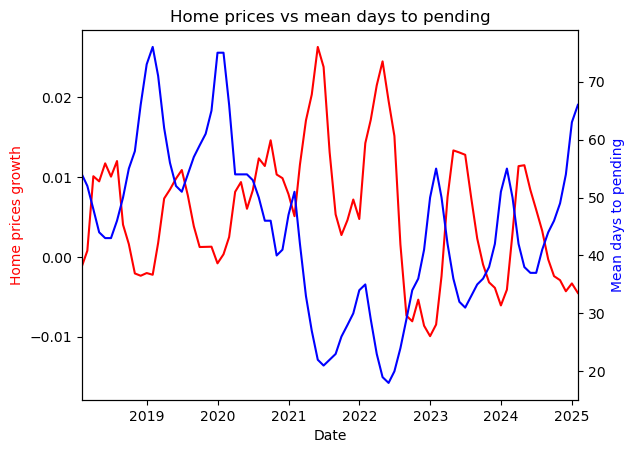

In [25]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth['date'], target_growth['United States'], 'r-') 
  
plt.title('Home prices vs mean days to pending')
ax1.set_xlim([max(target_growth['date'].min(), feature['date'].min()), \
          min(target_growth['date'].max(), feature['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Mean days to pending', color = 'blue') 
ax2.plot(feature['date'], feature['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and mean days to pending')

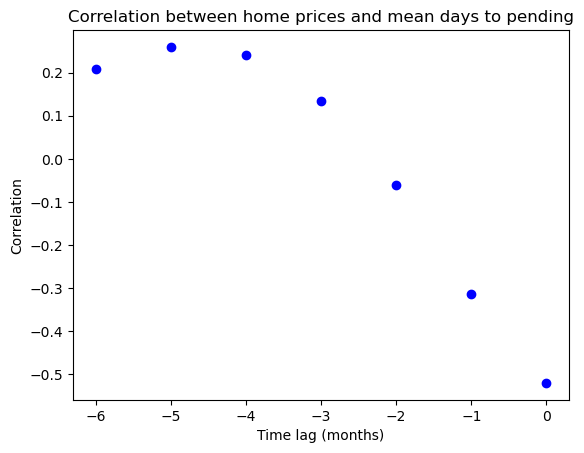

In [26]:
my_corr = rolling_corr(target_growth[['date', 'United States']],
                       feature[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and mean days to pending')

Seasonally adjusted data.

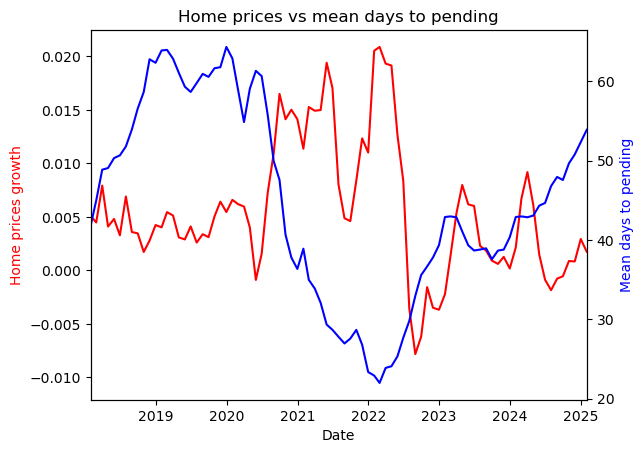

In [27]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth_sa['date'], target_growth_sa['United States'], 'r-') 
  
plt.title('Home prices vs mean days to pending')
ax1.set_xlim([max(target_growth_sa['date'].min(), feature_sa['date'].min()), \
          min(target_growth_sa['date'].max(), feature_sa['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Mean days to pending', color = 'blue') 
ax2.plot(feature_sa['date'], feature_sa['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and mean days to pending')

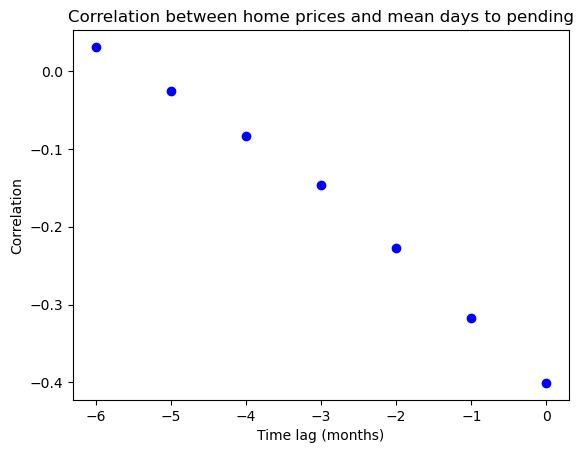

In [28]:
my_corr = rolling_corr(target_growth_sa[['date', 'United States']],
                       feature_sa[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and mean days to pending')

## Mean sale-to-list ratio

In [29]:
feature = pd.read_csv('data/2025_02/Metro_mean_sale_to_list_uc_sfrcondo_month.csv')
feature = feature.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])
feature = feature.rename(columns={'RegionName':'index'})
feature = feature.set_index('index')
feature = feature.stack().unstack(level=0)
feature = feature.reset_index()
feature = feature.rename(columns={'index': 'date'})
feature['date'] = pd.to_datetime(feature['date'])
feature = feature.sort_values(['date'])
feature_sa = feature[['date', 'United States']]
feature_sa['United States'] = remove_seasonality(feature_sa['United States'].to_numpy())

/var/folders/sy/trsj1fws3q56ylqm17n583900000gn/T/ipykernel_14616/3907245944.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_sa['United States'] = remove_seasonality(feature_sa['United States'].to_numpy())


Non-seasonally adjusted data.

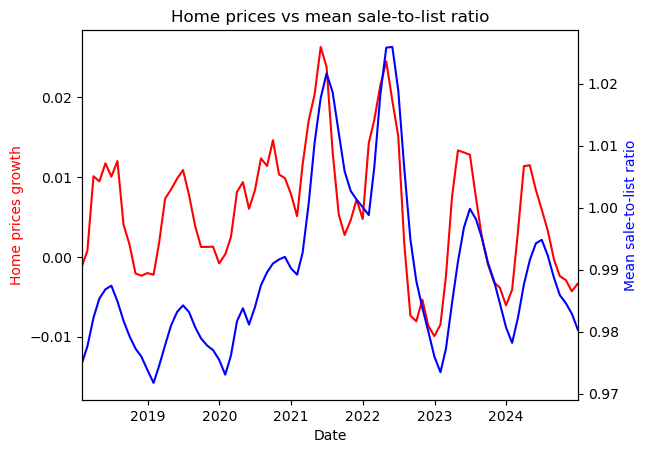

In [30]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth['date'], target_growth['United States'], 'r-') 
  
plt.title('Home prices vs mean sale-to-list ratio')
ax1.set_xlim([max(target_growth['date'].min(), feature['date'].min()), \
          min(target_growth['date'].max(), feature['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Mean sale-to-list ratio', color = 'blue') 
ax2.plot(feature['date'], feature['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and mean sale-to-list ratio')

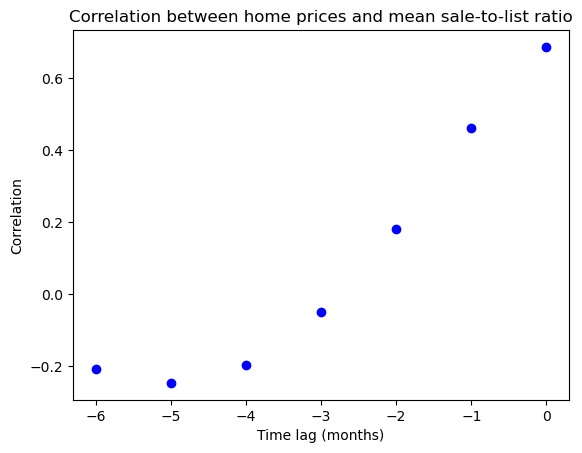

In [31]:
my_corr = rolling_corr(target_growth[['date', 'United States']],
                       feature[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and mean sale-to-list ratio')

Seasonally adjusted data.

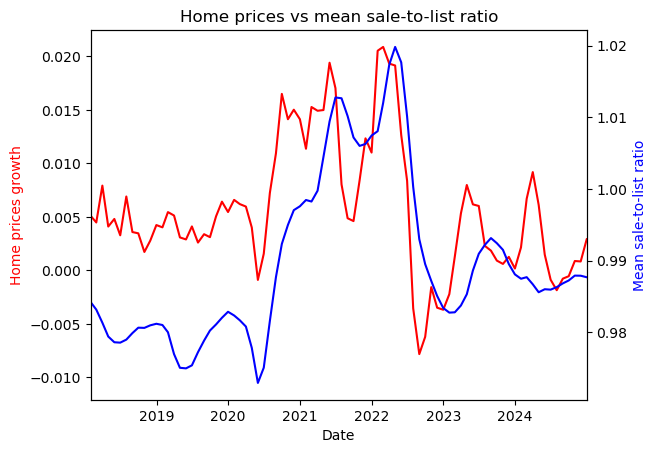

In [32]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth_sa['date'], target_growth_sa['United States'], 'r-') 
  
plt.title('Home prices vs mean sale-to-list ratio')
ax1.set_xlim([max(target_growth_sa['date'].min(), feature_sa['date'].min()), \
          min(target_growth_sa['date'].max(), feature_sa['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Mean sale-to-list ratio', color = 'blue') 
ax2.plot(feature_sa['date'], feature_sa['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and mean sale-to-list ratio')

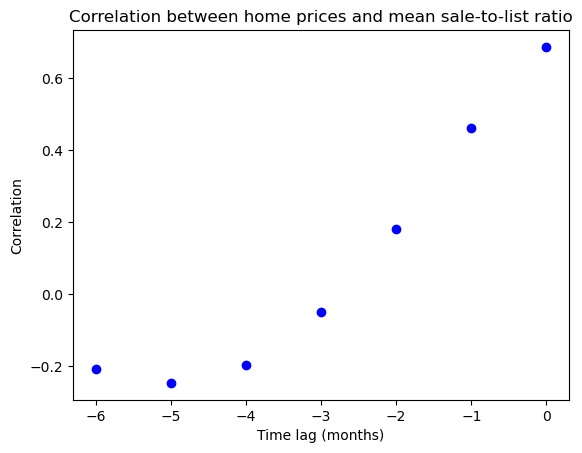

In [33]:
y_corr = rolling_corr(target_growth_sa[['date', 'United States']],
                       feature_sa[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and mean sale-to-list ratio')

## Median days to pending

In [34]:
feature = pd.read_csv('data/2025_02/Metro_med_doz_pending_uc_sfrcondo_month.csv')
feature = feature.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])
feature = feature.rename(columns={'RegionName':'index'})
feature = feature.set_index('index')
feature = feature.stack().unstack(level=0)
feature = feature.reset_index()
feature = feature.rename(columns={'index': 'date'})
feature['date'] = pd.to_datetime(feature['date'])
feature = feature.sort_values(['date'])
feature_sa = feature[['date', 'United States']]
feature_sa['United States'] = remove_seasonality(feature_sa['United States'].to_numpy())

/var/folders/sy/trsj1fws3q56ylqm17n583900000gn/T/ipykernel_14616/488244973.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_sa['United States'] = remove_seasonality(feature_sa['United States'].to_numpy())


Non-seasonally adjusted data.

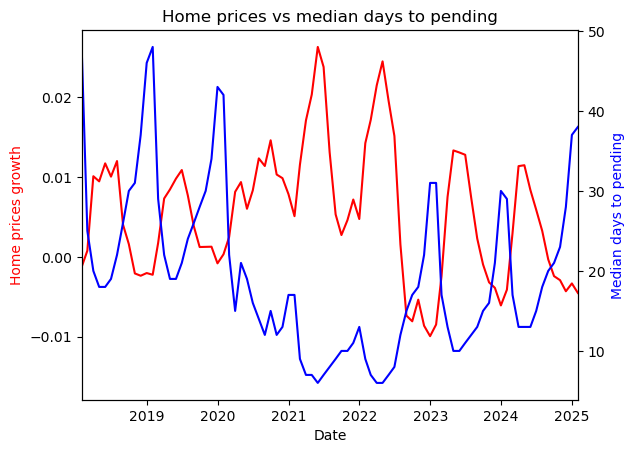

In [35]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth['date'], target_growth['United States'], 'r-') 
  
plt.title('Home prices vs median days to pending')
ax1.set_xlim([max(target_growth['date'].min(), feature['date'].min()), \
          min(target_growth['date'].max(), feature['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Median days to pending', color = 'blue') 
ax2.plot(feature['date'], feature['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and median days to pending')

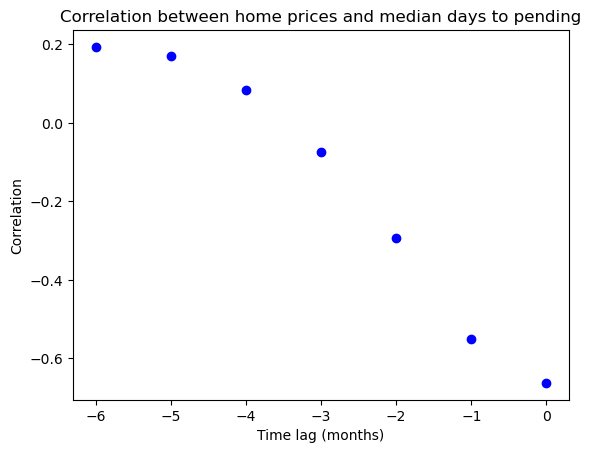

In [36]:
my_corr = rolling_corr(target_growth[['date', 'United States']],
                       feature[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and median days to pending')

Seasonally adjusted data.

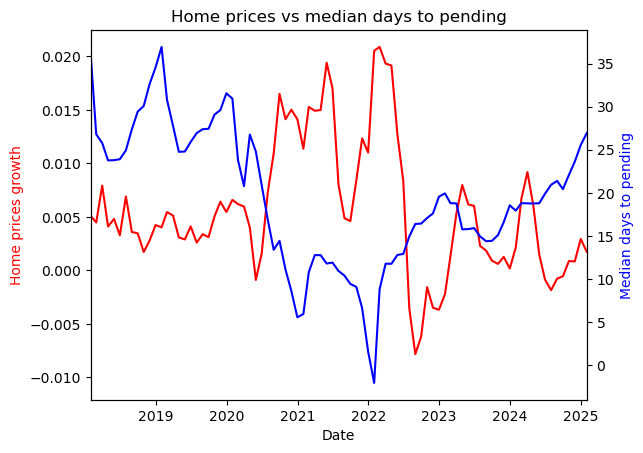

In [37]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth_sa['date'], target_growth_sa['United States'], 'r-') 
  
plt.title('Home prices vs median days to pending')
ax1.set_xlim([max(target_growth_sa['date'].min(), feature_sa['date'].min()), \
          min(target_growth_sa['date'].max(), feature_sa['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Median days to pending', color = 'blue') 
ax2.plot(feature_sa['date'], feature_sa['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and median days to pending')

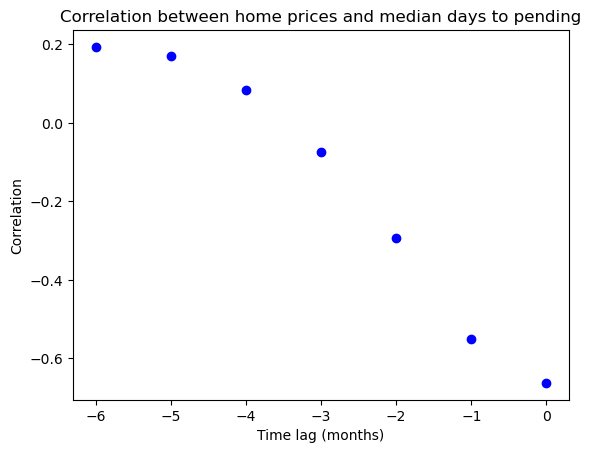

In [38]:
y_corr = rolling_corr(target_growth_sa[['date', 'United States']],
                       feature_sa[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and median days to pending')

## Median sale-to-list ratio

In [39]:
feature = pd.read_csv('data/2025_02/Metro_median_sale_to_list_uc_sfrcondo_month.csv')
feature = feature.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])
feature = feature.rename(columns={'RegionName':'index'})
feature = feature.set_index('index')
feature = feature.stack().unstack(level=0)
feature = feature.reset_index()
feature = feature.rename(columns={'index': 'date'})
feature['date'] = pd.to_datetime(feature['date'])
feature = feature.sort_values(['date'])
feature_sa = feature[['date', 'United States']]
feature_sa['United States'] = remove_seasonality(feature_sa['United States'].to_numpy())

/var/folders/sy/trsj1fws3q56ylqm17n583900000gn/T/ipykernel_14616/811993611.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_sa['United States'] = remove_seasonality(feature_sa['United States'].to_numpy())


Non-seasonally adjusted data.

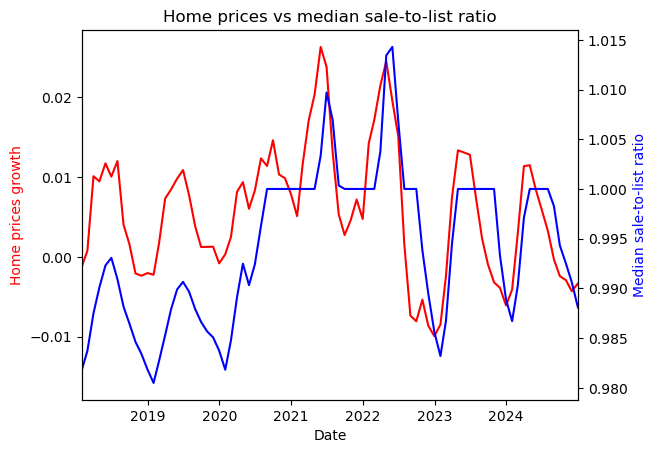

In [40]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth['date'], target_growth['United States'], 'r-') 
  
plt.title('Home prices vs median sale-to-list ratio')
ax1.set_xlim([max(target_growth['date'].min(), feature['date'].min()), \
          min(target_growth['date'].max(), feature['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Median sale-to-list ratio', color = 'blue') 
ax2.plot(feature['date'], feature['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and median sale-to-list ratio')

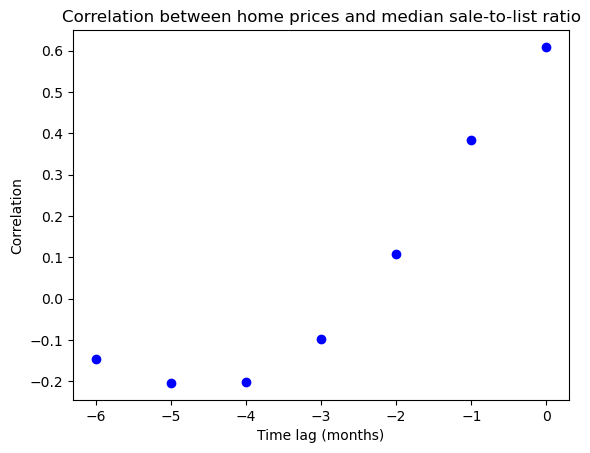

In [41]:
my_corr = rolling_corr(target_growth[['date', 'United States']],
                       feature[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and median sale-to-list ratio')

Seasonally adjusted data.

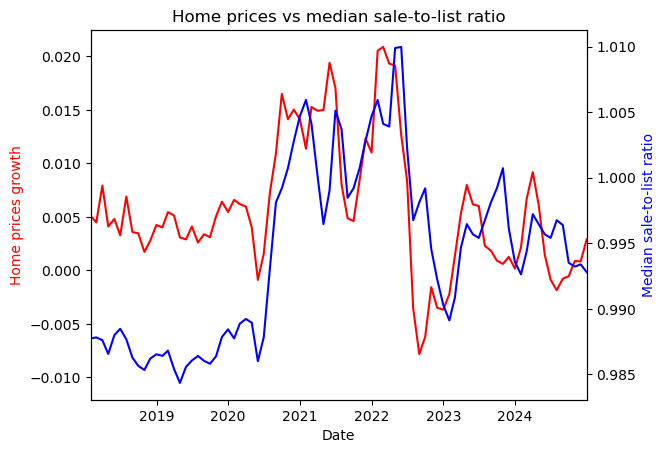

In [42]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth_sa['date'], target_growth_sa['United States'], 'r-') 
  
plt.title('Home prices vs median sale-to-list ratio')
ax1.set_xlim([max(target_growth_sa['date'].min(), feature_sa['date'].min()), \
          min(target_growth_sa['date'].max(), feature_sa['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Median sale-to-list ratio', color = 'blue') 
ax2.plot(feature_sa['date'], feature_sa['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and median sale-to-list ratio')

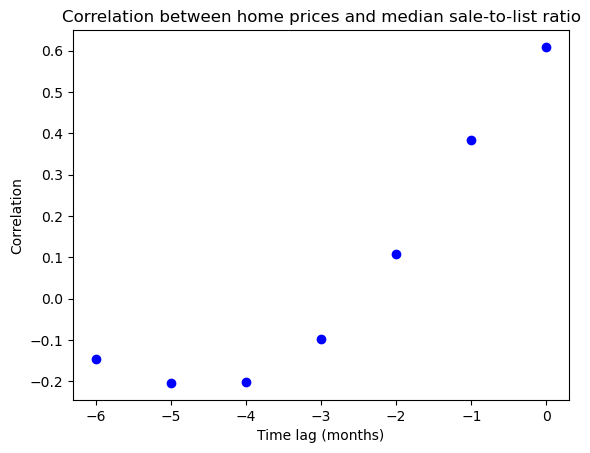

In [43]:
y_corr = rolling_corr(target_growth_sa[['date', 'United States']],
                       feature_sa[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and median sale-to-list ratio')

## Newly pending listings

In [44]:
feature = pd.read_csv('data/2025_02/Metro_new_pending_uc_sfrcondo_month.csv')
feature = feature.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])
feature = feature.rename(columns={'RegionName':'index'})
feature = feature.set_index('index')
feature = feature.stack().unstack(level=0)
feature = feature.reset_index()
feature = feature.rename(columns={'index': 'date'})
feature['date'] = pd.to_datetime(feature['date'])
feature = feature.sort_values(['date'])
feature_sa = feature[['date', 'United States']]
feature_sa['United States'] = remove_seasonality(feature_sa['United States'].to_numpy())

/var/folders/sy/trsj1fws3q56ylqm17n583900000gn/T/ipykernel_14616/2232909537.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_sa['United States'] = remove_seasonality(feature_sa['United States'].to_numpy())


Non-seasonally adjusted data.

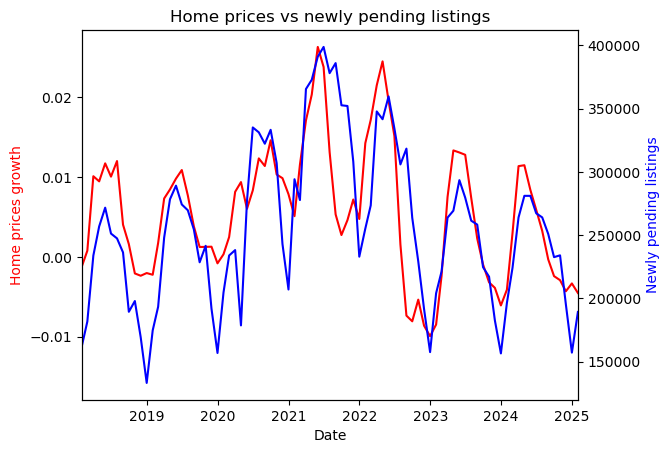

In [45]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth['date'], target_growth['United States'], 'r-') 
  
plt.title('Home prices vs newly pending listings')
ax1.set_xlim([max(target_growth['date'].min(), feature['date'].min()), \
          min(target_growth['date'].max(), feature['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Newly pending listings', color = 'blue') 
ax2.plot(feature['date'], feature['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and newly pending listings')

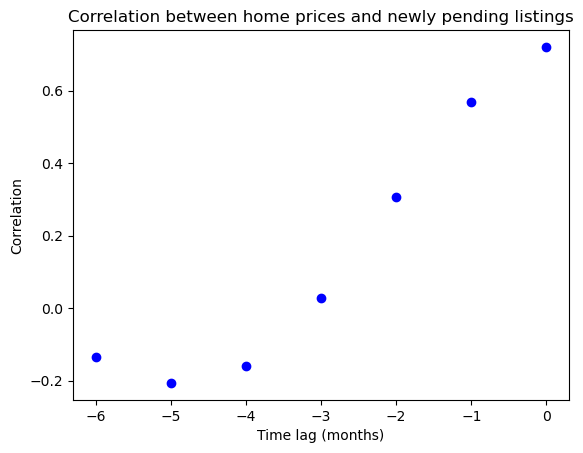

In [46]:
my_corr = rolling_corr(target_growth[['date', 'United States']],
                       feature[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and newly pending listings')

Seasonally adjusted data.

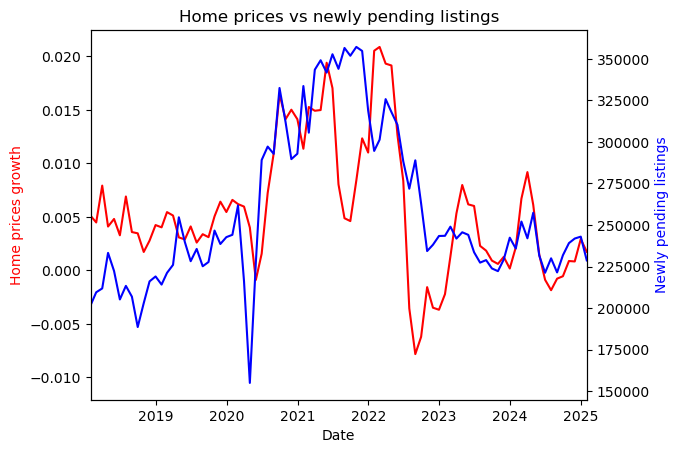

In [47]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth_sa['date'], target_growth_sa['United States'], 'r-') 
  
plt.title('Home prices vs newly pending listings')
ax1.set_xlim([max(target_growth_sa['date'].min(), feature_sa['date'].min()), \
          min(target_growth_sa['date'].max(), feature_sa['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Newly pending listings', color = 'blue') 
ax2.plot(feature_sa['date'], feature_sa['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and newly pending listings')

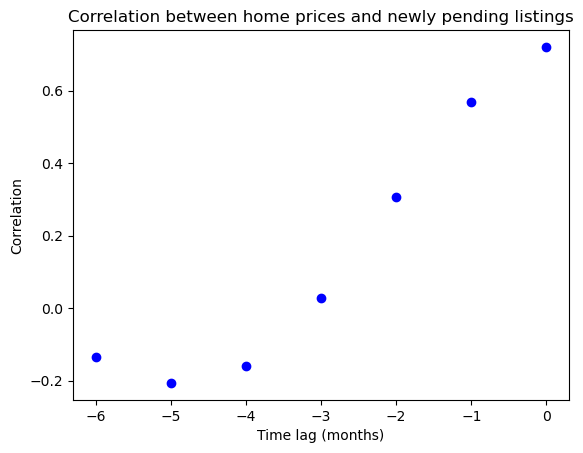

In [48]:
y_corr = rolling_corr(target_growth_sa[['date', 'United States']],
                       feature_sa[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and newly pending listings')

## Percentage of listings with price cut

In [49]:
feature = pd.read_csv('data/2025_02/Metro_perc_listings_price_cut_uc_sfrcondo_month.csv')
feature = feature.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])
feature = feature.rename(columns={'RegionName':'index'})
feature = feature.set_index('index')
feature = feature.stack().unstack(level=0)
feature = feature.reset_index()
feature = feature.rename(columns={'index': 'date'})
feature['date'] = pd.to_datetime(feature['date'])
feature = feature.sort_values(['date'])
feature_sa = feature[['date', 'United States']]
feature_sa['United States'] = remove_seasonality(feature_sa['United States'].to_numpy())

/var/folders/sy/trsj1fws3q56ylqm17n583900000gn/T/ipykernel_14616/1767327707.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_sa['United States'] = remove_seasonality(feature_sa['United States'].to_numpy())


Non-seasonally adjusted data.

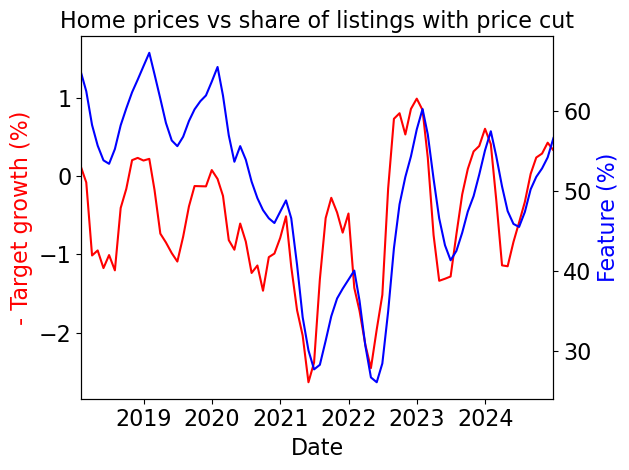

In [64]:
fig, ax1 = plt.subplots()
  
ax1.set_xlabel('Date', fontsize=16) 
ax1.set_ylabel('- Target growth (%)', color = 'red', fontsize=16) 
ax1.plot(target_growth['date'], - 100 * target_growth['United States'], 'r-') 
  
plt.title('Home prices vs share of listings with price cut', fontsize=16)
ax1.set_xlim([max(target_growth['date'].min(), feature['date'].min()), \
          min(target_growth['date'].max(), feature['date'].max())])
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

ax2 = ax1.twinx() 
ax2.set_ylabel('Feature (%)', color = 'blue', fontsize=16) 
ax2.plot(feature['date'], 100 * feature['United States'], 'b-') 
ax2.tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.savefig('figures/target_feature.eps', format='eps')
plt.show()

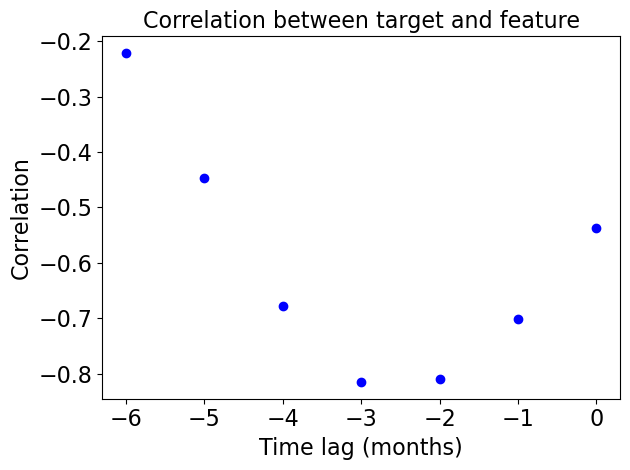

In [51]:
my_corr = rolling_corr(target_growth[['date', 'United States']],
                       feature[['date', 'United States']], 6)

fig, ax = plt.subplots() 

plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)', fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.title('Correlation between target and feature', fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.savefig('figures/target_feature_correlation.eps', format='eps')
plt.show()

Seasonally adjusted data.

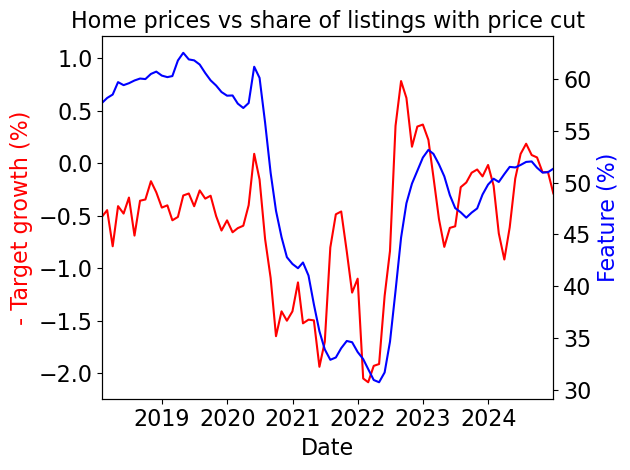

In [65]:
fig, ax1 = plt.subplots()
  
ax1.set_xlabel('Date', fontsize=16) 
ax1.set_ylabel('- Target growth (%)', color = 'red', fontsize=16) 
ax1.plot(target_growth_sa['date'], - 100 * target_growth_sa['United States'], 'r-') 
  
plt.title('Home prices vs share of listings with price cut', fontsize=16)
ax1.set_xlim([max(target_growth_sa['date'].min(), feature_sa['date'].min()), \
          min(target_growth_sa['date'].max(), feature_sa['date'].max())])
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

ax2 = ax1.twinx() 
ax2.set_ylabel('Feature (%)', color = 'blue', fontsize=16) 
ax2.plot(feature_sa['date'], 100 * feature_sa['United States'], 'b-') 
ax2.tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.savefig('figures/target_feature_sa.eps', format='eps')
plt.show()

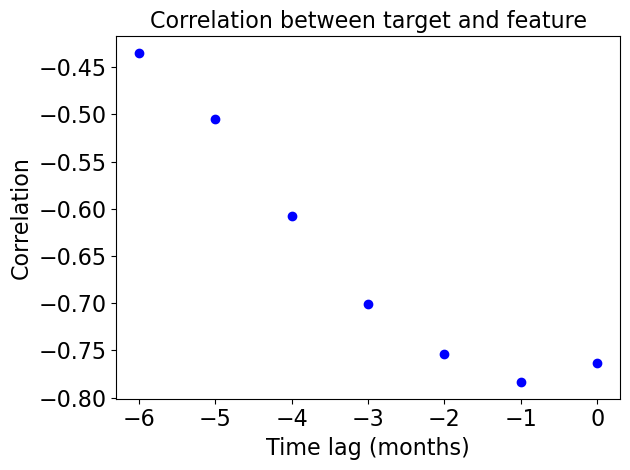

In [53]:
my_corr = rolling_corr(target_growth_sa[['date', 'United States']],
                       feature_sa[['date', 'United States']], 6)

fig, ax = plt.subplots() 

plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)', fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.title('Correlation between target and feature', fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.savefig('figures/target_feature_correlation_sa.eps', format='eps')
plt.show()

## Percentage sold above list price

In [54]:
feature = pd.read_csv('data/2025_02/Metro_pct_sold_above_list_uc_sfrcondo_month.csv')
feature = feature.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])
feature = feature.rename(columns={'RegionName':'index'})
feature = feature.set_index('index')
feature = feature.stack().unstack(level=0)
feature = feature.reset_index()
feature = feature.rename(columns={'index': 'date'})
feature['date'] = pd.to_datetime(feature['date'])
feature = feature.sort_values(['date'])
feature_sa = feature[['date', 'United States']]
feature_sa['United States'] = remove_seasonality(feature_sa['United States'].to_numpy())

/var/folders/sy/trsj1fws3q56ylqm17n583900000gn/T/ipykernel_14616/1738316322.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_sa['United States'] = remove_seasonality(feature_sa['United States'].to_numpy())


Non-seasonally adjusted data.

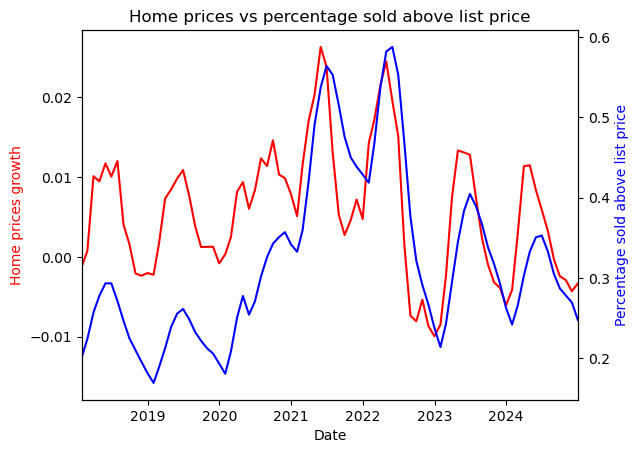

In [55]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth['date'], target_growth['United States'], 'r-') 
  
plt.title('Home prices vs percentage sold above list price')
ax1.set_xlim([max(target_growth['date'].min(), feature['date'].min()), \
          min(target_growth['date'].max(), feature['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Percentage sold above list price', color = 'blue') 
ax2.plot(feature['date'], feature['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and percentage sold above list price')

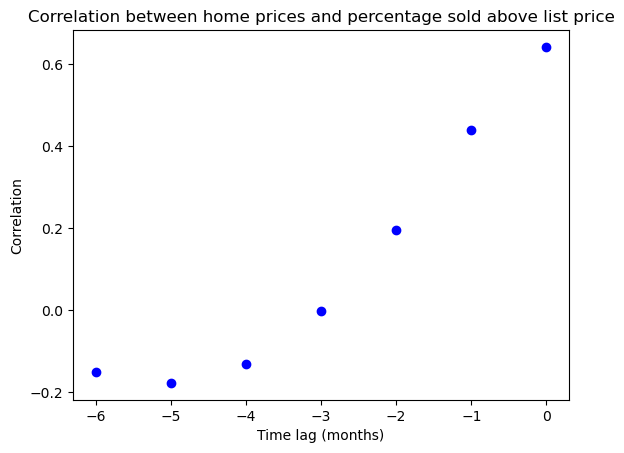

In [56]:
my_corr = rolling_corr(target_growth[['date', 'United States']],
                       feature[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and percentage sold above list price')

Seasonally adjusted data.

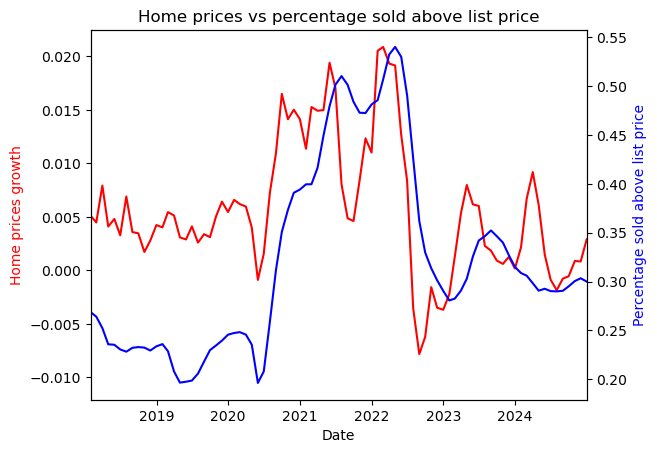

In [57]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth_sa['date'], target_growth_sa['United States'], 'r-') 
  
plt.title('Home prices vs percentage sold above list price')
ax1.set_xlim([max(target_growth_sa['date'].min(), feature_sa['date'].min()), \
          min(target_growth_sa['date'].max(), feature_sa['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Percentage sold above list price', color = 'blue') 
ax2.plot(feature_sa['date'], feature_sa['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and percentage sold above list price')

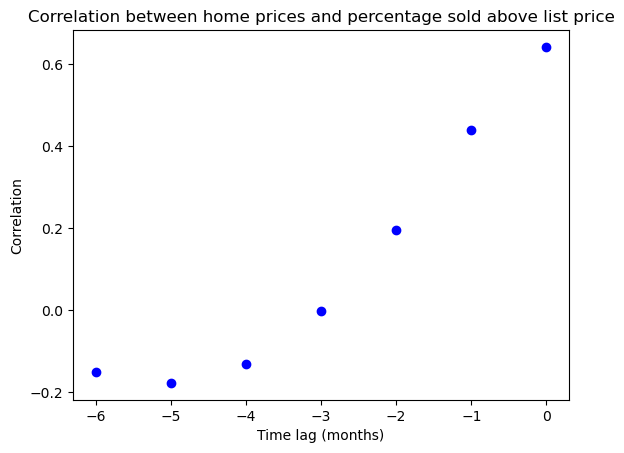

In [58]:
y_corr = rolling_corr(target_growth_sa[['date', 'United States']],
                       feature_sa[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and percentage sold above list price')

## Percentage sold below list price

In [59]:
feature = pd.read_csv('data/2025_02/Metro_pct_sold_below_list_uc_sfrcondo_month.csv')
feature = feature.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])
feature = feature.rename(columns={'RegionName':'index'})
feature = feature.set_index('index')
feature = feature.stack().unstack(level=0)
feature = feature.reset_index()
feature = feature.rename(columns={'index': 'date'})
feature['date'] = pd.to_datetime(feature['date'])
feature = feature.sort_values(['date'])
feature_sa = feature[['date', 'United States']]
feature_sa['United States'] = remove_seasonality(feature_sa['United States'].to_numpy())

/var/folders/sy/trsj1fws3q56ylqm17n583900000gn/T/ipykernel_14616/464725927.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_sa['United States'] = remove_seasonality(feature_sa['United States'].to_numpy())


Non-seasonally adjusted data.

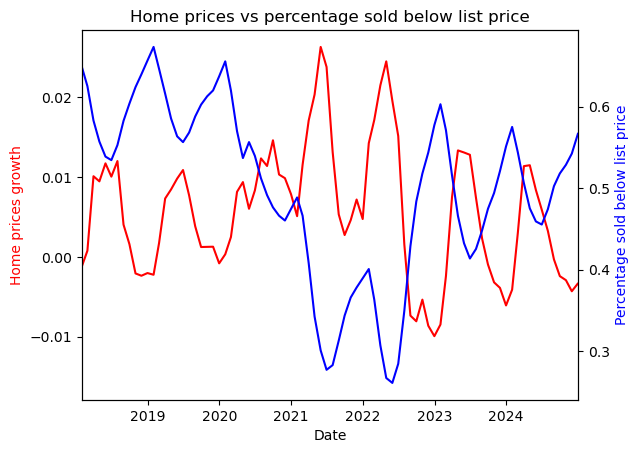

In [60]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth['date'], target_growth['United States'], 'r-') 
  
plt.title('Home prices vs percentage sold below list price')
ax1.set_xlim([max(target_growth['date'].min(), feature['date'].min()), \
          min(target_growth['date'].max(), feature['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Percentage sold below list price', color = 'blue') 
ax2.plot(feature['date'], feature['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and percentage sold below list price')

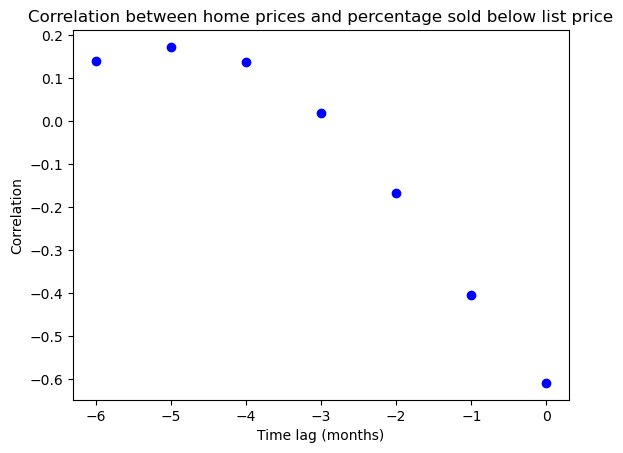

In [61]:
my_corr = rolling_corr(target_growth[['date', 'United States']],
                       feature[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and percentage sold below list price')

Seasonally adjusted data.

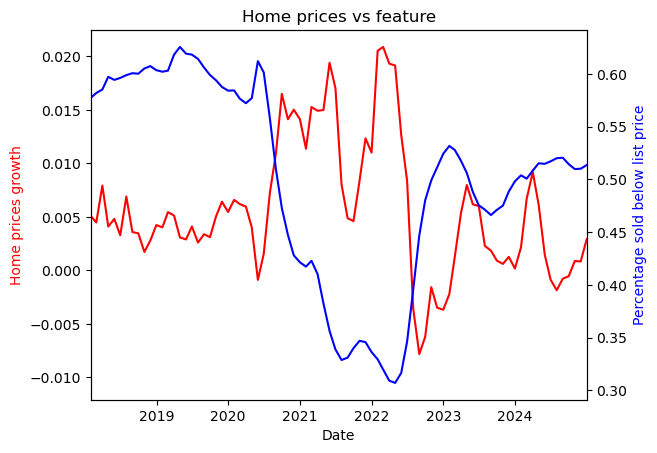

In [62]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth_sa['date'], target_growth_sa['United States'], 'r-') 
  
plt.title('Home prices vs feature')
ax1.set_xlim([max(target_growth_sa['date'].min(), feature_sa['date'].min()), \
          min(target_growth_sa['date'].max(), feature_sa['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Percentage sold below list price', color = 'blue') 
ax2.plot(feature_sa['date'], feature_sa['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and percentage sold below list price')

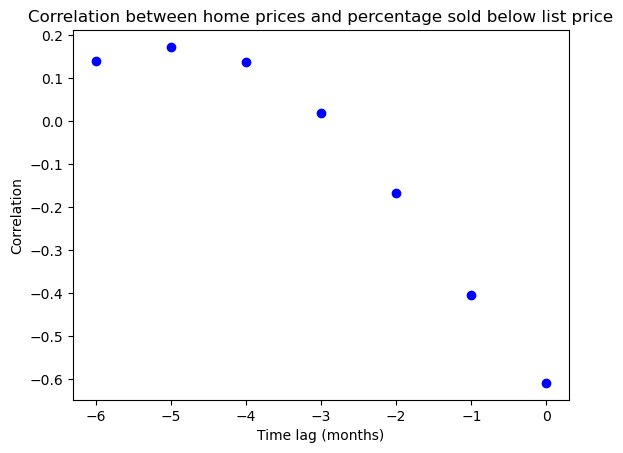

In [63]:
y_corr = rolling_corr(target_growth_sa[['date', 'United States']],
                       feature_sa[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and percentage sold below list price')

## Conclusion

We will test the linear regression for all these features, except mortgage rates, which has a small correlation coefficient.